# Gemini 2.5 Flash Baseline: Analysis

**Objective:** This notebook reads the raw API outputs generated by `1-baseline-api-calls.ipynb`, applies our standardized evaluation logic, and produces the final results CSVs and performance metrics.

**Methodology:**
1.  Load the same test sets again to access ground-truth labels.
2.  Replicate the exact parsing and evaluation logic from the main project's `final-testing.md` notebook for a fair comparison.
3.  For each sample, read the raw API outputs, parse them, and determine the final predicted classification.
4.  Generate and save the final results DataFrames and performance reports.

In [11]:
### Cell 1: Setup and Configuration

import pandas as pd
import numpy as np
import re
import json
import math
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm

# --- Path Definitions ---
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
BASELINE_DIR = NOTEBOOK_DIR
DATA_DIR = PROJECT_ROOT / "data"
RAW_INPUT_DIR = BASELINE_DIR / "results" / "raw_api_outputs"
FINAL_RESULTS_DIR = BASELINE_DIR / "results"

print(f"Project Root: {PROJECT_ROOT}")
print(f"Reading raw API outputs from: {RAW_INPUT_DIR}")
print(f"Final results will be saved to: {FINAL_RESULTS_DIR}")

Project Root: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math
Reading raw API outputs from: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/baseline/results/raw_api_outputs
Final results will be saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/baseline/results


In [12]:
### Cell 2: Load Test Data

SFT_TEST_SET_PATH = DATA_DIR / "final-datasets" / "error_detection_dataset.csv"
FINAL_TEST_SET_PATH = DATA_DIR / "final-datasets" / "final-test-with-wrong-answers.csv"

# --- 1. Process the Final Test Set (Identical to final-testing.md) ---
final_test_raw_df = pd.read_csv(FINAL_TEST_SET_PATH)

final_test_data = []
for idx, row in final_test_raw_df.iterrows():
    # Append the correct version of the solution
    final_test_data.append({
        "index": idx, # use the test set index
        "question": row["question"],
        "answer": row["correct_answer"],
        "error_type": "correct"
    })
    # Append the flawed version of the solution
    error = "conceptual_error" if row["error_type"] == "concep" else "computational_error"
    final_test_data.append({
        "index": idx,
        "question": row["question"],
        "answer": row["wrong_answer"],
        "error_type": error
    })
final_test_df = pd.DataFrame(final_test_data)


# --- 2. Process the SFT Test Set (Identical to final-testing.md) ---
sft_full_df = pd.read_csv(SFT_TEST_SET_PATH)
sft_test_df_filtered = sft_full_df[sft_full_df['split'] == 'test']

sft_test_data = []
for _, row in sft_test_df_filtered.iterrows():
    if row["error_type"] == "correct":
        answer = row["correct_answer"]
    else:
        answer = row["wrong_answer"]
    sft_test_data.append({
        "index": row["index"], # use the original gsm8k index
        "question": row["question"],
        "answer": answer,
        "error_type": row["error_type"]
    })
sft_test_df = pd.DataFrame(sft_test_data)


# --- 3. Final Verification ---
print(f"Loaded {len(sft_test_df)} samples from the SFT test set.")
print(f"Loaded {len(final_test_df)} samples from the final test set.")

# Verify that the 'answer' column exists and other columns are consistent
print(f"\nSFT Test Set Columns: {sft_test_df.columns.tolist()}")
print(f"Final Test Set Columns: {final_test_df.columns.tolist()}")

Loaded 1214 samples from the SFT test set.
Loaded 302 samples from the final test set.

SFT Test Set Columns: ['index', 'question', 'answer', 'error_type']
Final Test Set Columns: ['index', 'question', 'answer', 'error_type']


In [13]:
### Cell 3: Replicated Evaluation Logic

# These functions are copied from the project's `final-testing.md` notebook to ensure the evaluation logic is identical.

def extract_equation_from_response(response: str) -> str | None:
    """Extracts content from between <eq> and </eq> tags."""
    if not isinstance(response, str): return None
    match = re.search(r'<eq>(.*?)</eq>', response, re.DOTALL)
    return match.group(1) if match else None

def sanitize_equation_string(expression: str) -> str:
    """Cleans an equation string."""
    if not isinstance(expression, str): return ""
    sanitized = expression.strip().replace(' ', '').replace('x', '*').replace('×', '*')
    sanitized = re.sub(r'[^\d.()+\-*/=]', '', sanitized)
    return sanitized

def evaluate_sanitized_equation(eq_str: str) -> bool:
    """
    Evaluates a sanitized equation string.
    Returns True if a computational error is found, False otherwise.
    """
    if not eq_str or "=" not in eq_str:
        return False
    try:
        lhs, rhs_str = eq_str.split('=', 1)
        if not lhs or not rhs_str: return False
        
        lhs_val = eval(lhs, {"__builtins__": None}, {})
        rhs_val = float(rhs_str)
        
        # Return True if a computational error is found (values do not match)
        return not math.isclose(lhs_val, rhs_val, rel_tol=1e-2)
    except Exception:
        # A parsing or eval error means we couldn't confirm a computational error.
        return False

print("Evaluation logic replicated.")

Evaluation logic replicated.


In [14]:
### Cell 4: Main Processing Function

def process_baseline_sample(df_index, row, test_set_name):
    """Reads raw files, applies evaluation logic, and returns a results dictionary."""
    # 1. Determine the correct index for file naming
    if test_set_name == "sft_test_set":
        file_index = row['index']
    else:
        file_index = df_index

    # 2. Process Conceptual Check
    conceptual_path = RAW_INPUT_DIR / "conceptual_check" / test_set_name / f"{file_index}.txt"
    try:
        conceptual_verdict_raw = conceptual_path.read_text(encoding='utf-8').strip().lower()
        if 'correct' in conceptual_verdict_raw:
            conceptual_verdict = 'correct'
        else:
            conceptual_verdict = 'conceptual_error'
    except FileNotFoundError:
        conceptual_verdict = 'conceptual_error'

    # 3. Process Computational Check
    has_computational_error = False
    solution_lines = [line.strip() for line in row['answer'].strip().split('\n') if line.strip()]
    raw_equations = []
    
    for i, line in enumerate(solution_lines):
        comp_path = RAW_INPUT_DIR / "computational_check" / test_set_name / f"{file_index}_line_{i+1}.txt"
        try:
            raw_response = comp_path.read_text(encoding='utf-8')
            extracted_eq = extract_equation_from_response(raw_response)
            raw_equations.append(extracted_eq if extracted_eq is not None else "")
            sanitized_eq = sanitize_equation_string(extracted_eq)
            
            if evaluate_sanitized_equation(sanitized_eq):
                has_computational_error = True
        except FileNotFoundError:
            raw_equations.append("ERROR: FILE NOT FOUND")
            continue

    # 4. Final Verdict Logic
    if has_computational_error:
        pred_error_type = 'computational_error'
    else:
        pred_error_type = conceptual_verdict
        
    # --- FIX IS HERE ---
    # The ground truth label is now correctly retrieved AND included in the output.
    true_error_type = row['error_type']

    return {
        'index': file_index,
        'question': row['question'],
        'answer': row['answer'],
        'true_error_type': true_error_type, # <-- THIS LINE WAS MISSING
        'pred_error_type': pred_error_type,
        'raw_equations': json.dumps(raw_equations),
        'is_correct': (true_error_type == pred_error_type),
    }

print("Main processing function defined.")

Main processing function defined.


In [15]:
### Cell 5: Run Analysis and Save Results

def run_full_analysis(test_df, test_set_name):
    """Iterates through a test set, processes each sample, and saves the results."""
    print(f"\n--- Running analysis for {test_set_name} ---")
    results = []
    for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"Analyzing {test_set_name}"):
        # Pass the DataFrame index `index` as df_index
        result = process_baseline_sample(index, row, test_set_name)
        results.append(result)
    
    results_df = pd.DataFrame(results)
    output_path = FINAL_RESULTS_DIR / f"{test_set_name}_results_baseline.csv"
    results_df.to_csv(output_path, index=False)
    print(f"✅ Results saved to {output_path}")
    return results_df

In [16]:
final_results_df = run_full_analysis(final_test_df, "final_test_set")


--- Running analysis for final_test_set ---


Analyzing final_test_set:   0%|          | 0/302 [00:00<?, ?it/s]

✅ Results saved to /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/baseline/results/final_test_set_results_baseline.csv


In [17]:
sft_results_df = run_full_analysis(sft_test_df, "sft_test_set")


--- Running analysis for sft_test_set ---


Analyzing sft_test_set:   0%|          | 0/1214 [00:00<?, ?it/s]

✅ Results saved to /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/baseline/results/sft_test_set_results_baseline.csv


<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


In [18]:
print(final_results_df.info())
print(sft_results_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            302 non-null    int64 
 1   question         302 non-null    object
 2   answer           302 non-null    object
 3   true_error_type  302 non-null    object
 4   pred_error_type  302 non-null    object
 5   raw_equations    302 non-null    object
 6   is_correct       302 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 14.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            1214 non-null   int64 
 1   question         1214 non-null   object
 2   answer           1214 non-null   object
 3   true_error_type  1214 non-null   object
 4   pred_error_type  1214 non-null   object
 5   

In [19]:
### Cell 6: Compute and Display Final Metrics

def compute_final_metrics(results_df: pd.DataFrame, title: str):
    """Computes and displays key performance metrics and visualizations."""
    print("\n" + "="*80)
    print(f"PERFORMANCE REPORT: {title}")
    print("="*80)
    
    y_true = results_df['true_error_type']
    y_pred = results_df['pred_error_type']
    labels = sorted(list(set(y_true) | set(y_pred)))

    # --- 1. Classification Report ---
    print("Classification Report")
    print("-" * 80)
    report = classification_report(y_true, y_pred, labels=labels, zero_division=0)
    print(report)

    # --- 2. Confusion Matrices ---
    print("\n" + "Confusion Matrices")
    print("-" * 80)
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Baseline Performance Analysis: {title}', fontsize=20)

    cm_raw = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})
    axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=16)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)

    cm_norm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})
    axes[1].set_title('Normalized Confusion Matrix (% of True Label)', fontsize=16)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


🚀 Displaying final performance metrics...

PERFORMANCE REPORT: SFT Test Set (Baseline)
Classification Report
--------------------------------------------------------------------------------
                     precision    recall  f1-score   support

computational_error       0.84      0.30      0.45       400
   conceptual_error       0.56      0.87      0.68       414
            correct       0.64      0.67      0.65       400

           accuracy                           0.62      1214
          macro avg       0.68      0.61      0.59      1214
       weighted avg       0.68      0.62      0.59      1214


Confusion Matrices
--------------------------------------------------------------------------------


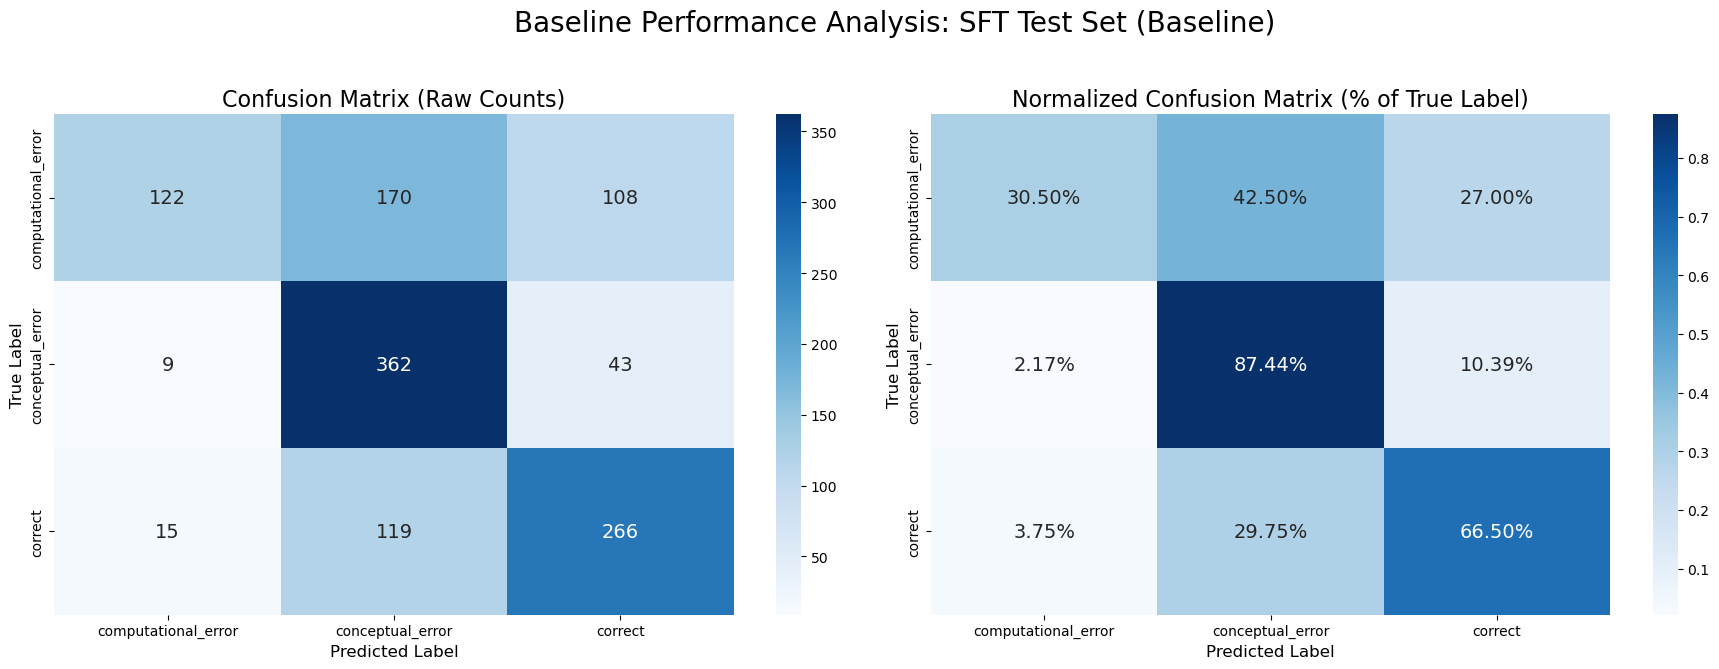


PERFORMANCE REPORT: Final Test Set (Baseline)
Classification Report
--------------------------------------------------------------------------------
                     precision    recall  f1-score   support

computational_error       0.88      0.91      0.89        75
   conceptual_error       0.83      0.82      0.82        76
            correct       0.91      0.91      0.91       151

           accuracy                           0.88       302
          macro avg       0.87      0.88      0.88       302
       weighted avg       0.88      0.88      0.88       302


Confusion Matrices
--------------------------------------------------------------------------------


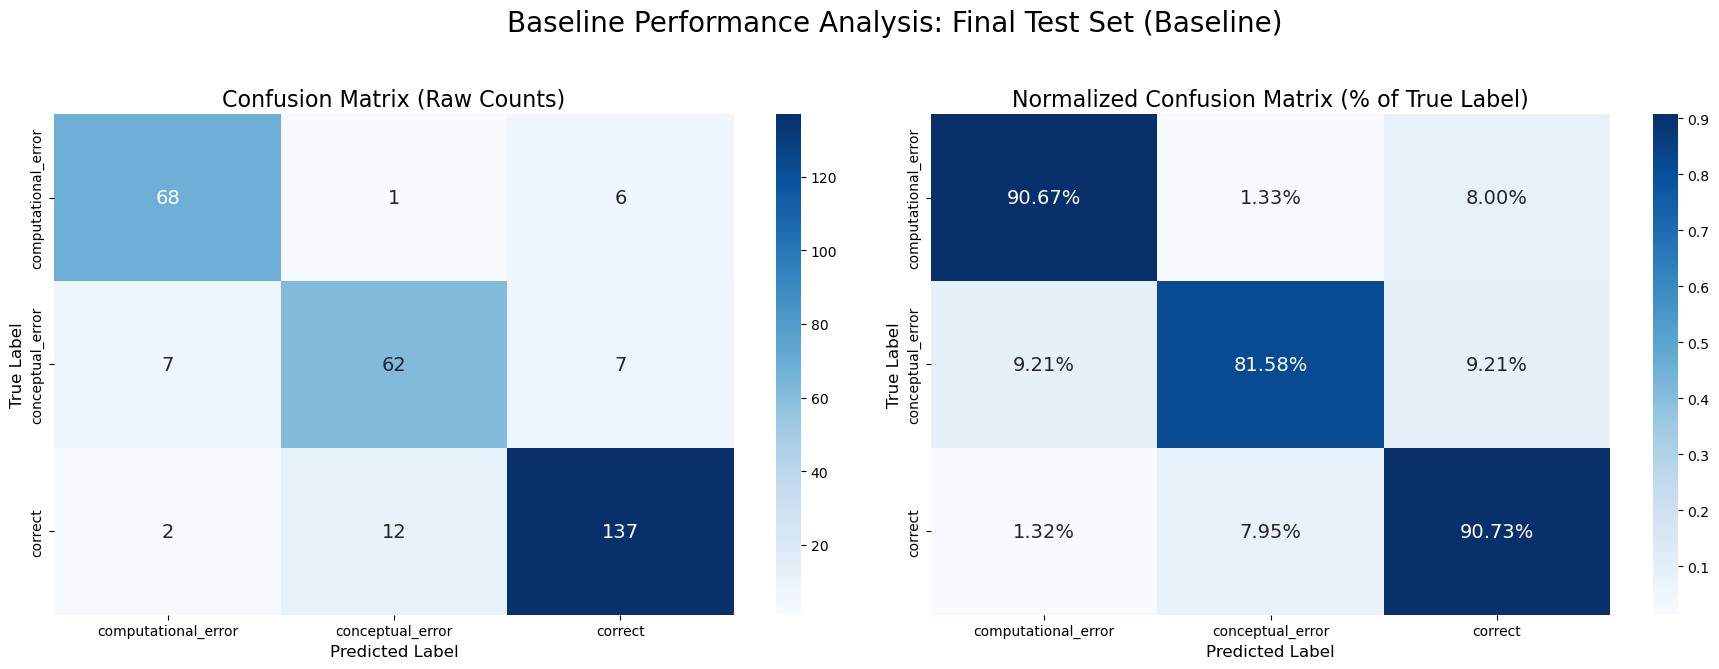

In [20]:
# --- Display reports for both test sets ---
print("\n🚀 Displaying final performance metrics...")
compute_final_metrics(sft_results_df, "SFT Test Set (Baseline)")
compute_final_metrics(final_results_df, "Final Test Set (Baseline)")